# Analista para el operador de telecomunicaciones Megaline
La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de los planes genera más ingresos para poder ajustar el presupuesto de publicidad.

El proyecto se divide en 4 etapas:
1. Abrir el archivo de datos 
2. Estudiar la información general y preparar los datos
3. Analizar los datos
4. Prueba de las hipótesis

Objetivo: Determinar qué plan, en promedio, aporta más ingresos

# Descripción de las tarifas
Nota: Megaline redondea los segundos a minutos y los megabytes a gigabytes. Para llamadas, cada llamada individual se redondea: incluso si la llamada duró solo un segundo, se contará como un minuto. Para tráfico web, las sesiones web individuales no se redondean. En vez de esto, el total del mes se redondea hacia arriba. Si alguien usa 1025 megabytes este mes, se le cobrarán 2 gigabytes.

A continuación puedes ver una descripción de las tarifas:

Surf
1. Pago mensual: 20
2. 500 minutos al mes, 50 SMS y 15 GB de datos.
3. Si se exceden los límites del paquete:
    - 1 minuto: 3 centavos.
    - 1 SMS: 3 centavos.
    - 1 GB de datos: 10.
    
Ultimate
1. Pago mensual: 70.
2. 3000 minutos al mes, 1000 SMS y 30 GB de datos.
3. Si se exceden los límites del paquete:
    - 1 minuto: 1 centavo.
    - 1 SMS: 1 centavo.
    - 1 GB de datos: 7.

# Diccionario de datos
Se tiene  cinco tablas diferentes.

1. La tabla users (datos sobre los usuarios):
- user_id: identificador único del usuario.
- first_name: nombre del usuario.
- last_name: apellido del usuario.
- age: edad del usuario (en años).
- reg_date: fecha de suscripción (dd, mm, aa).
- churn_date: la fecha en la que el usuario dejó de usar el servicio (si el valor es ausente, la tarifa se estaba usando cuando fue extraída esta base de datos).
- city: ciudad de residencia del usuario.
- plan: nombre de la tarifa.

2. La tabla calls (datos sobre las llamadas):
- id: identificador único de la llamada.
- call_date: fecha de la llamada.
- duration: duración de la llamada (en minutos).
- user_id: el identificador del usuario que realiza la llamada.

3. La tabla messages (datos sobre los SMS):
- id: identificador único del SMS.
- message_date: fecha del SMS.
- user_id: el identificador del usuario que manda el SMS.

4. La tabla internet (datos sobre las sesiones web):
- id: identificador único de la sesión.
- mb_used: el volumen de datos gastados durante la sesión (en megabytes).
- session_date: fecha de la sesión web.
- user_id: identificador del usuario.

5. La tabla plans (datos sobre las tarifas):
- plan_name: nombre de la tarifa.
- usd_monthly_fee: pago mensual en dólares estadounidenses.
- minutes_included: minutos incluidos al mes.
- messages_included: SMS incluidos al mes.
- mb_per_month_included: datos incluidos al mes (en megabytes).
- usd_per_minute: precio por minuto tras exceder los límites del paquete (por ejemplo, si el paquete incluye 100 minutos, el operador cobrará el minuto 101).
- usd_per_message: precio por SMS tras exceder los límites del paquete.
- usd_per_gb: precio por gigabyte de los datos extra tras exceder los límites del paquete (1 GB = 1024 megabytes).

## Abrir el archivo de datos

Se importan las librerías que se van a utilizar:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import math
import seaborn as sns

Se leen y examinan los archivos que contiene los datos: 

In [2]:
calls = pd.read_csv('/datasets/megaline_calls.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users.csv')

## Estudiar la información general y Preparar los datos

### Planes

In [10]:
#Extraer la información general
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


El dataframe se puede leer tal cual está. Casi todos los datos son enteros, a excepción de los precios que son decimales y el nombre del plan que es una palabra y no hay valores ausentes.

Corregir datos:

In [11]:
#Pasar los mb a gb, porque el cobro se hace en gb
plans['mb_per_month_included'] = plans['mb_per_month_included']/1024 

#Renombrar la unidad de medida para mayor claridad
plans.rename(columns={'mb_per_month_included': 'gb_per_month_included'}, inplace=True) 

### Usuarios

In [12]:
#Extraer la información general
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Los datos se pueden leer sin necesidad de establecer algún parámetro extra. En la columna 'churn_date' hay valores ausentes, sin embargo se sabe que esto corresponde a usuarios que aún estaban usando la tarifa en el momento en que fue extraída la base de datos. Para mejor manejo de los datos, las columnas 'reg_date' y 'churn_date' se pueden modificar de objet a datetime.

Corregir datos:

In [15]:
#Pasar la columna 'reg_date' a datetime
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d') 

#Pasar la columna 'churn_date' a datetime
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d') 

In [17]:
#Verifica que no haya duplicados
users[users.duplicated()]

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date


### Llamadas

In [4]:
#Extraigo la información general
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


Para mejor manejo de los datos se puede pasar a datetime la columna 'call_date' y ya que la compañía redondea las llamadas, también se puede pasar la duración de las llamadas a enteros. No hay valores ausentes.

In [6]:
#Imprimo una muestra de los datos
calls.head(20)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
5,1000_388,1000,2018-12-31,2.20
6,1000_510,1000,2018-12-27,5.75
7,1000_521,1000,2018-12-28,14.18
8,1000_530,1000,2018-12-28,5.77
9,1000_544,1000,2018-12-26,4.40


En las llamadas que tienen una duración de 0, pueden ser llamadas que salieron o entraron, pero que inmediatamente se cayeron.

Corregir datos:

In [8]:
#Cambiar el tipo de datos de las fechas
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d') 

#Redondear la duración de las llamadas hacia arriba, ya que esto influye en el cobro 
calls['duration'] = calls['duration'].apply(np.ceil) 

In [9]:
#Verifica que no haya duplicados
calls[calls.duplicated()]

,id,user_id,call_date,duration


### Mensajes

In [19]:
#Estraer información general
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


No hay valores ausentes. Es mejor manejar la fechas en el formato adecuado.

In [20]:
#Cambiar la columna 'message_date' a datetime
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d') 

In [21]:
#Verifica que no haya duplicados
messages[messages.duplicated()]

,id,user_id,message_date


### Internet

In [22]:
#Extraer la información general
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


Al igual que en los dataframe anteriores, por ahora solo es necesario cambiar el tipo de la columna de la fecha de la sesión web. No hay valores ausentes.

Corregir datos:

In [23]:
#Cambia la columna 'message_date' a datetime
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d') 

In [24]:
#Pasar las unidades de mb a gb
internet['mb_used']=internet['mb_used']/1024 

#Redondear el consumo de mb hacia arriba
internet['mb_used'] = internet['mb_used'].apply(np.ceil) 

#Renombrar la columna de mb a gb
internet = internet.rename(columns={'mb_used': 'gb_used'}) 

In [25]:
#Verificar si valores duplicados
internet[internet.duplicated()]

,id,user_id,session_date,gb_used


## Analizar los datos

Estudiar las condiciones de las tarifas:

In [44]:
plans

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


Calcular el número de llamadas hechas por cada usuario al mes:

In [34]:
#Crear una columna que contenta los meses
calls['month'] = calls['call_date'].dt.month 

#Agrupar las columnas 'user_id' y 'month' y contar 'id'
calls_month = calls.groupby(['user_id', 'month'])['id'].count().reset_index(name='total_calls') #agrupo las columnas 'user_id' y 'month' y se comparan con el conteo de 'id'

calls_month.head(2)

,user_id,month,total_calls
0,1000,12,16
1,1001,8,27


Calcular los minutos usados por cada usuario al mes:

In [35]:
#Agrupar las columnas 'user_id' y 'month' y se comparan con el conteo de 'id'
mins_month = calls.groupby(['user_id', 'month'])['duration'].sum().reset_index(name='total_mins') 
mins_month.head(2)

,user_id,month,total_mins
0,1000,12,124.0
1,1001,8,182.0


Calcular el número de mensajes enviados por cada usuario al mes:

In [36]:
#Crear una columna con los meses
messages['month'] = messages['message_date'].dt.month 

#Agrupar 'user_id' y 'month'
sms_month = messages.groupby(['user_id', 'month'])['id'].count().reset_index(name='total_sms') 
sms_month.head(2)

,user_id,month,total_sms
0,1000,12,11
1,1001,8,30


Calcula el volumen del tráfico de Internet usado por cada usuario al mes:

In [37]:
#Crear una columna que contenga solo los meses
internet['month'] = internet['session_date'].dt.month 

#Agrupo el dataframe por 'user_id' y 'month'
gb_month = internet.groupby(['user_id', 'month'])['gb_used'].sum().reset_index(name='total_gb') 
gb_month.head(2)

,user_id,month,total_gb
0,1000,12,4.0
1,1001,8,21.0


Fusionar los datos de llamadas, minutos, mensajes e Internet con base en user_id y month:

In [38]:
#Combinar los dataframes de la duración de las llamadas y los mensajes enviados
mins_sms = mins_month.merge(sms_month, on=['user_id', 'month']) 

#Combinar el dataframe anterior con el de los consumos de datos
fusion = mins_sms.merge(gb_month, on=['user_id', 'month']) 

fusion.head(2)

,user_id,month,total_mins,total_sms,total_gb
0,1000,12,124.0,11,4.0
1,1001,8,182.0,30,21.0


Añadir la información de la tarifa:

In [39]:
#Extraer las columnas que se necesitan de users para combinar con el datafame fusionado, 
#más la de ciudad que se necesita para más adelante
user = users[['user_id','plan', 'city']] 

#Combinar el df de los planes con el df que tiene la inforemación fusionada
all = user.merge(fusion, on=['user_id']) 

all.head(2)

,user_id,plan,city,month,total_mins,total_sms,total_gb
0,1000,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",12,124.0,11,4.0
1,1001,surf,"Seattle-Tacoma-Bellevue, WA MSA",8,182.0,30,21.0


Calcular el ingreso mensual para cada usuario:

In [42]:
#Combinar el dt fusionado con plans para tener las tarifas
df = all.merge(plans, left_on='plan', right_on='plan_name') 

#Eliminar la columna 'plan_name', para no tener dos columnas con la misma información
df = df.drop('plan_name', axis=1) 

#Calcular los mins, mensajes y gb extras que se gastaron

#Minutos
df['mins'] = np.ceil(df['total_mins'])-df['minutes_included']

#Mensajes
df['sms'] = df['total_sms']-df['messages_included'] 

#Gigabytes
df['data'] = np.ceil(df['total_gb'])-df['gb_per_month_included'] 

#Sobre cargo que tiene cada usuario por los minutos, mensajes y gb demás que usaron
df['charge_mins'] = np.where(df[ 'mins'] > 0, df[ 'mins'] * df['usd_per_minute'],0)
df['charge_sms'] = np.where(df[ 'sms'] > 0, df[ 'sms'] * df['usd_per_message'],0)
df['charge_data'] = np.where(df[ 'data'] > 0, df[ 'data'] * df['usd_per_gb'],0)


#Sumar la tarifa mensual, con el sobre cargo
df['income']=df['usd_monthly_pay'] + df[ 'charge_mins'] + df[ 'charge_sms'] + df['charge_data']

#Ingreso mensual por usuario
df[['user_id', 'plan','month', 'income']].head(2)

,user_id,plan,month,income
0,1000,ultimate,12,70.0
1,1006,ultimate,11,70.0


### Llamadas

Comparar la duración promedio de llamadas por cada plan y por cada mes:

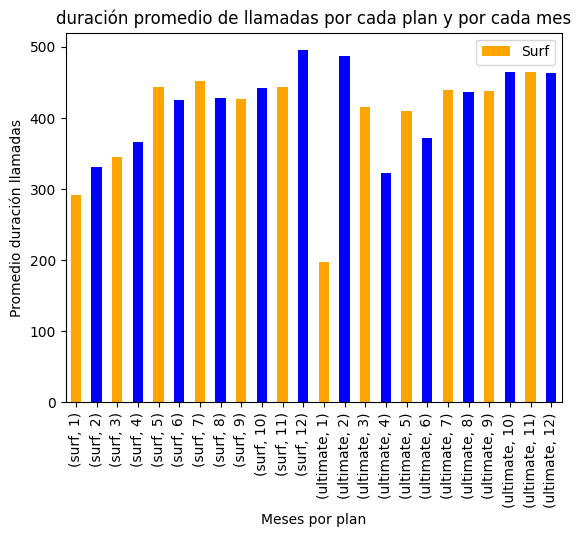

In [47]:
calls_mean = all.groupby(['plan', 'month'])['total_mins'].mean()

calls_mean.plot(kind = 'bar', 
                title= 'Duración promedio de llamadas por cada plan y por cada mes', 
                xlabel = 'Meses por plan', 
                ylabel = 'Promedio duración llamadas',
               color = ['orange', 'blue'])

plt.legend(['Surf', 'Utilmate'])
plt.show()

Comparar el número de minutos mensuales que necesitan los usuarios de cada plan:

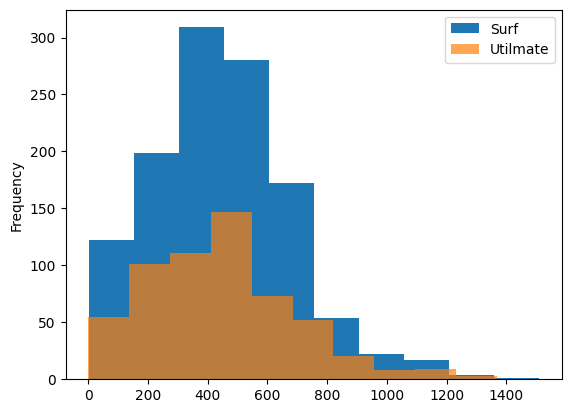

In [48]:
all[all['plan'] == 'surf']['total_mins'].plot(kind='hist')
all[all['plan'] == 'ultimate']['total_mins'].plot(kind='hist', alpha=0.7)

plt.legend(['Surf', 'Utilmate'])
plt.show()

Calcular la media y la varianza de la duración mensual de llamadas:

In [49]:
mean_surf_calls = (all[all['plan'] == 'surf']['total_mins']).mean()
print('mean_surf:', mean_surf_calls)

mean_ultimate_calls = (all[all['plan'] == 'ultimate']['total_mins']).mean()
print('mean_ultimate:', mean_ultimate_calls)

print()

var_surf_calls = np.var(all[all['plan'] == 'surf']['total_mins'])
print('var_surf:', var_surf_calls)

var_ultimate_calls = np.var(all[all['plan'] == 'ultimate']['total_mins'])
print('var_ultimate:', var_ultimate_calls)

mean_surf: 445.77542372881356
mean_ultimate: 442.51295336787564

var_surf: 55274.530073972994
var_ultimate: 62180.81978039679


Distribución de la duración mensual de llamadas:

<AxesSubplot:xlabel='total_mins'>

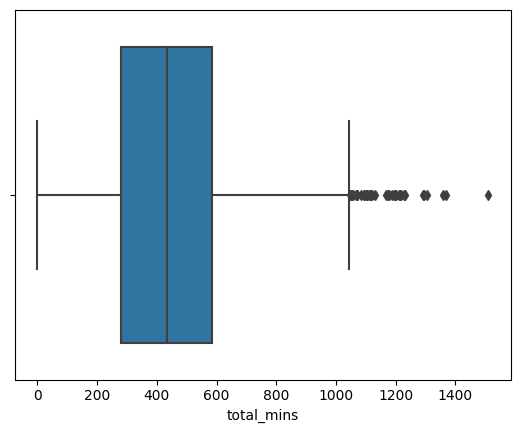

In [50]:
sns.boxplot(all['total_mins'])

En términos generales se puede observar que el plan 'surf' tiene un poco más de actividad en cuando a la duración de las llamadas promedio al mes. Sin embargo, no es una diferencia muy significativa. 

Esto es respaldado por el comportamiento mensual de cada uno de los planes (diagrama barras). Con el diagrama de cajas se puede observar que pasar de los 1000 minutos al mes, es algo atípico.

Por otro lado, se puede ver que en cuanto a la frecuencia de llamadas, el plan 'surf' es el que más actividad tiene.

### Mensajes

Comparar el número de mensajes que tienden a enviar cada mes los usuarios de cada plan:

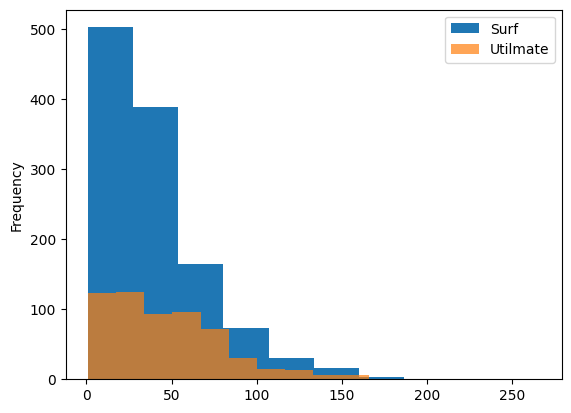

In [51]:
all[all['plan'] == 'surf']['total_sms'].plot(kind='hist')
all[all['plan'] == 'ultimate']['total_sms'].plot(kind='hist', alpha=0.7)

plt.legend(['Surf', 'Utilmate'])
plt.show()

Comparar el promedio del número de mensaje por cada plan y por cada mes:

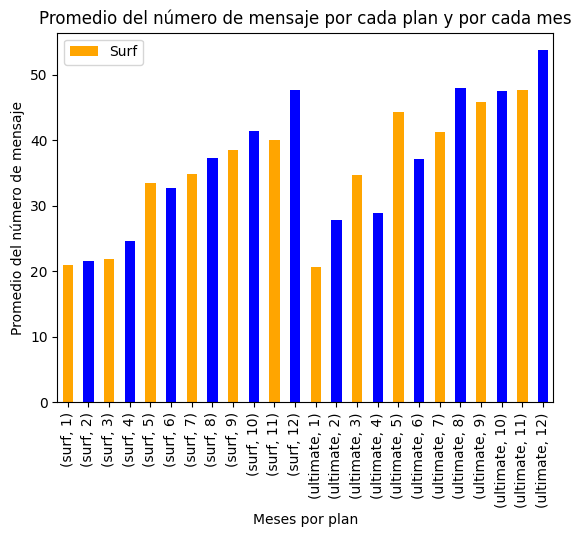

In [52]:
calls_mean = all.groupby(['plan', 'month'])['total_sms'].mean()

calls_mean.plot(kind = 'bar', 
                title= 'Promedio del número de mensaje por cada plan y por cada mes', 
                xlabel = 'Meses por plan', 
                ylabel = 'Promedio del número de mensaje', 
                color = ['orange', 'blue'])

plt.legend(['Surf', 'Utilmate'])
plt.show()

Calcular la media y la varianza de número de mensajes al mes:

In [53]:
mean_surf_sms = (all[all['plan'] == 'surf']['total_sms']).mean()
print('mean_surf:', mean_surf_sms)

mean_ultimate_sms = (all[all['plan'] == 'ultimate']['total_sms']).mean()
print('mean_ultimate:', mean_ultimate_sms)

print()

var_surf_sms = np.var(all[all['plan'] == 'surf']['total_sms'])
print('var_surf:', var_surf_sms)

var_ultimate_sms = np.var(all[all['plan'] == 'ultimate']['total_sms'])
print('var_ultimate:', var_ultimate_sms)

mean_surf: 39.489830508474576
mean_ultimate: 46.4559585492228

var_surf: 1043.3329474288998
var_ultimate: 1082.5209446338606


De nuevo se puede observar que en cuanto a la frecuencia de mensajes, el plan `Surf` es el que más actividad tiene. 

Para ambos planes los primeros meses del mes son los que menos actividad tienen y los últimos los que más, siendo en ambos casos el mes de `diciembre` cuando más mensajes se envían. 

Evaluando la media, en el plan `Ultimate` es donde más mensajes de texto se envían en promedio.


### Internet

Comparar la cantidad de tráfico de Internet consumido por usuarios por plan:

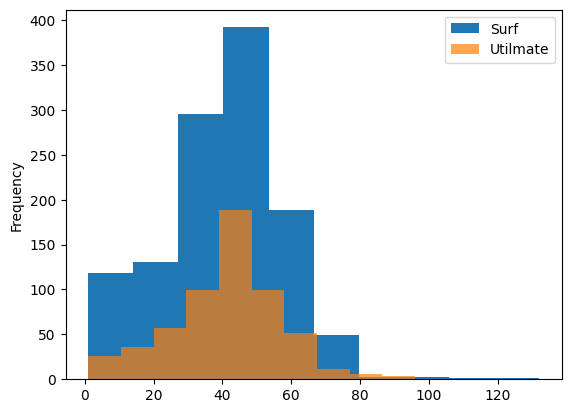

In [55]:
all[all['plan'] == 'surf']['total_gb'].plot(kind='hist')
all[all['plan'] == 'ultimate']['total_gb'].plot(kind='hist', alpha=0.7)

plt.legend(['Surf', 'Utilmate'])
plt.show()

Comparar el promedio de gb usado por cada plan y por cada mes:

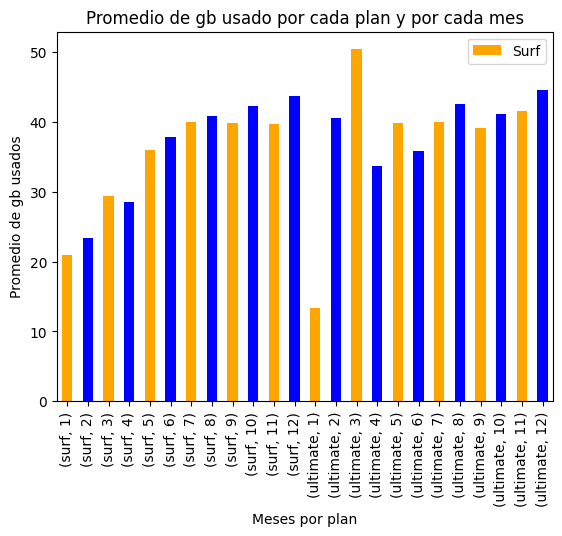

In [56]:
calls_mean = all.groupby(['plan', 'month'])['total_gb'].mean()

calls_mean.plot(kind = 'bar', 
                title= 'Promedio de gb usado por cada plan y por cada mes', 
                xlabel = 'Meses por plan', 
                ylabel = 'Promedio de gb usados', 
                color = ['orange', 'blue'])

plt.legend(['Surf', 'Utilmate'])
plt.show()

Calcular la media y la varianza del consumo de intenert al mes:


In [57]:
mean_surf_datos = (all[all['plan'] == 'surf']['total_gb']).mean()
print('mean_surf:', mean_surf_datos)

mean_ultimate_datos = (all[all['plan'] == 'ultimate']['total_gb']).mean()
print('mean_ultimate:', mean_ultimate_datos)

print()

var_surf_datos = np.var(all[all['plan'] == 'surf']['total_gb'])
print('var_surf:', var_surf_datos)

var_ultimate_datos = np.var(all[all['plan'] == 'ultimate']['total_gb'])
print('var_ultimate:', var_ultimate_datos)

mean_surf: 40.26864406779661
mean_ultimate: 41.134715025906736

var_surf: 300.98461002585464
var_ultimate: 249.2219209464236


En cuando al uso de internet, ambos planes tienen un comportamiento muy similar a lo largo del año a excepción de los meses de enero y marzo en el plan `Ultimate`, ya que en uno fue muy bajo en consumo (enero) y en el otro fue mucho más elevado de lo normal (marzo). Esto es confirmado con la media, ya que para ambos planes es la misma.


### Ingresos

Comparar el ingreso generado por usuarios por plan:


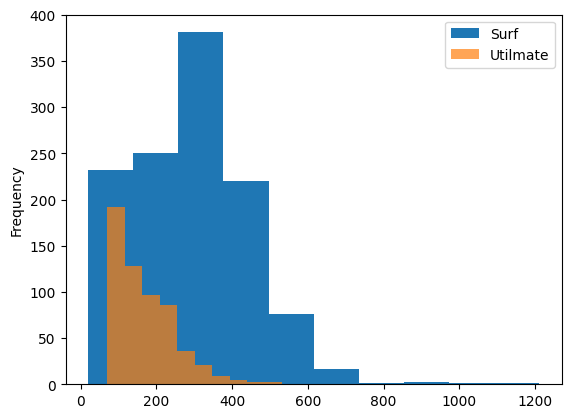

In [58]:
df[df['plan'] == 'surf']['income'].plot(kind='hist')
df[df['plan'] == 'ultimate']['income'].plot(kind='hist', alpha=0.7)

plt.legend(['Surf', 'Utilmate'])

plt.show()

Calcular la media y la varianza de los ingresos por plan:


In [59]:
mean_surf_income = (df[df['plan'] == 'surf']['income']).mean()
print('mean_surf:', mean_surf_income)

mean_ultimate_income = (df[df['plan'] == 'ultimate']['income']).mean()
print('mean_ultimate:', mean_ultimate_income)

print()

var_surf_income = np.var(df[df['plan'] == 'surf']['income'])
print('var_surf:', var_surf_income)

var_ultimate_income = np.var(df[df['plan'] == 'ultimate']['income'])
print('var_ultimate:', var_ultimate_income)

mean_surf: 282.82261864406786
mean_ultimate: 165.07426597582037

var_surf: 25476.5641281427
var_ultimate: 7147.978940523385


Comparar el ingreso promedio por cada plan y por cada mes:


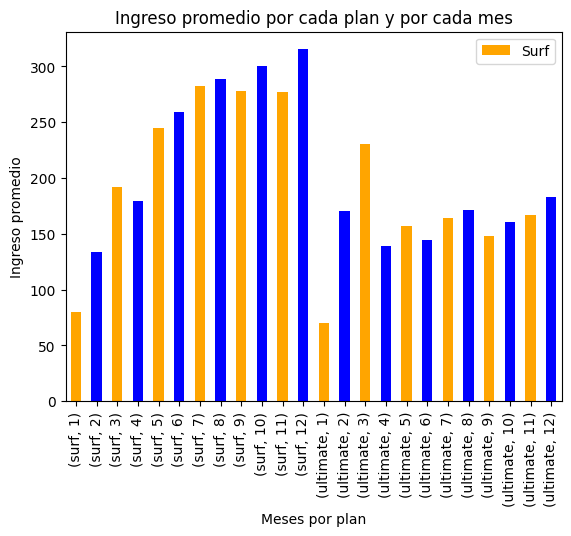

In [60]:
income_mean = df.groupby(['plan', 'month'])['income'].mean()

income_mean.plot(kind = 'bar', 
                title= 'Ingreso promedio por cada plan y por cada mes', 
                xlabel = 'Meses por plan', 
                ylabel = 'Ingreso promedio', 
                color = ['orange', 'blue'])

plt.legend(['Surf', 'Utilmate'])
plt.show()

En el histograma se puede evidenciar una gran diferencia en cuento a los ingresos por cada plan. El ingreso de `Surf` es mucho más alto que el de `Ultimate`, esto puede ser debido a que el plan `Surf` tiene menos minutos, mensajes y datos, por lo que es más fácil que los clientes se pasen en sus límites y deban pagar el sobrecosto. Sin embargo, al hacer el diagrama de barras y el promedio y varianza por cada plan se evidente que el plan `Ultimate` es el que genera mayores ingresos a la compañía.


## Prueba las hipótesis estadísticas

Hipótesis 1: Son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf

In [61]:
surf_income = (df[df['plan'] == 'surf']['income'])
ultimate_income = (df[df['plan'] == 'ultimate']['income'])

alpha = 0.05

result = st.ttest_ind(surf_income, ultimate_income,equal_var = False)

print('valor-p:', result.pvalue)

if (result.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

valor-p: 1.0052255610544789e-81
Rechazamos la hipótesis nula


Hipótesis 2: El ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones

In [62]:
income_NY_NJ = (df[df['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['income'])
income_others = (df[df['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']['income'])

alpha = 0.05

result = st.ttest_ind(income_NY_NJ, income_others, equal_var = False)

print('valor-p:', result.pvalue)

if (result.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

valor-p: 0.20786207648480143
No podemos rechazar la hipótesis nula


Con estas hipótesis, se puede decir que los ingresos por plan no son iguales.

# Conclusión

En general creo que el comportamiento de los usuarios de los planes `Surf` y `Ultimate` son muy similares. Sin embargo, se puede evidenciar que el ingreso del plan `Ultimate` es ligeramente más alto que el del plan Surf, por lo que le recomendaría a la empresa invertir un poco más en publicidad para el plan `Ultimate`, ya que parece ser el que genera más ingresos.